In [1]:
%%capture
!pip install catboost

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, f1_score

In [4]:
def plot_feature_vs_target(df, col, target_col):
    """
    Plots relationship of any feature with target_col.
    Numeric features -> scatter plot with trendline
    Categorical features -> bar plot
    """
    plt.figure(figsize=(7, 5))

    # Numeric features
    if pd.api.types.is_numeric_dtype(df[col]):
        sns.scatterplot(data=df, x=col, y=target_col, alpha=0.5)
        sns.regplot(data=df, x=col, y=target_col,
                    scatter=False, color='red', ci=None)  # trendline
        plt.title(f"{col} vs {target_col} (Numeric)")

    # Categorical features
    else:
        avg_values = df.groupby(col)[target_col].mean().reset_index()
        sns.barplot(data=avg_values, x=col, y=target_col)
        plt.title(f"{col} vs {target_col} (Categorical)")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


In [5]:
df=pd.read_csv('train_v9rqX0R.csv')
df_orig=df.copy()

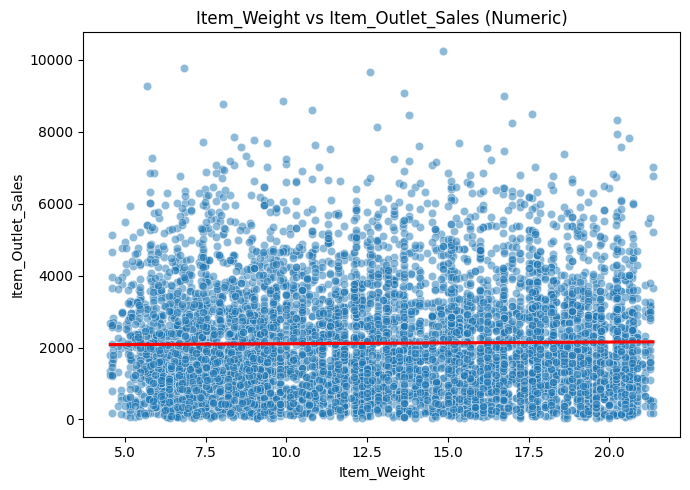

In [7]:
plot_feature_vs_target(df_orig, "Item_Weight", "Item_Outlet_Sales")

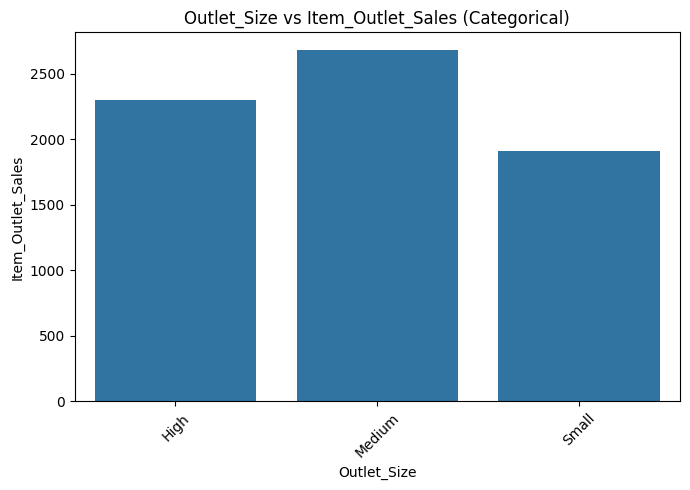

In [8]:
plot_feature_vs_target(df_orig, "Outlet_Size", "Item_Outlet_Sales")

In [9]:
df['Item_Fat_Content_Flag']='Regular'
df.loc[df['Item_Fat_Content'].isin(['LF', 'low fat','Low Fat']),'Item_Fat_Content_Flag']='LowFat'
df['Item_Fat_Content'] = df['Item_Fat_Content_Flag']
df = df.drop('Item_Fat_Content_Flag', axis=1)

In [10]:
df['Item_Units_Sold'] = df['Item_Outlet_Sales'] / df['Item_MRP']

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

regressors = [
    # LinearRegression(),
    # Ridge(alpha=1.0),
    # Lasso(alpha=0.001),
    RandomForestRegressor(n_estimators=200, random_state=42),
    # ExtraTreesRegressor(n_estimators=200, random_state=7, n_jobs=-1),
    # ExtraTreesRegressor(n_estimators=200, random_state=7),
    # ExtraTreesRegressor(n_estimators=1000, random_state=7, n_jobs=-1),
    # GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42),
    # HistGradientBoostingRegressor(max_iter=300, learning_rate=0.05, random_state=42),
    # KNeighborsRegressor(n_neighbors=5),
    # SVR(kernel="rbf", C=1.0, epsilon=0.1),
    # XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1),
    # LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=-1, random_state=42),
    # CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, random_state=42, verbose=0)
]


In [12]:
# Item_Weight Imputation
item_features = ['Item_Fat_Content',
                 'Item_Visibility',
                 'Item_Type',
                 'Item_MRP']

true_vals = df.loc[df['Item_Weight'].notnull(), 'Item_Weight']
features = df.loc[df['Item_Weight'].notnull(), item_features]

item_cat = ['Item_Fat_Content', 'Item_Type']
item_num = ['Item_Visibility', 'Item_MRP']

mask_idx = np.random.choice(true_vals.index, size=int(0.2*len(true_vals)), replace=False)
masked = features.copy()
masked.loc[mask_idx, :] = masked.loc[mask_idx, :]
fake_missing = true_vals.copy()
fake_missing.loc[mask_idx] = np.nan

item_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), item_cat),
        ('num', 'passthrough', item_num)
    ])

for regressor in regressors:
    weight_model = Pipeline(steps=[
      ('preprocess', item_preprocessor),
      ('regressor', regressor)
    ])

    weight_model.fit(features.drop(mask_idx), true_vals.drop(mask_idx))
    preds = weight_model.predict(features.loc[mask_idx])

    print(regressor)
    print("Item_Weight Imputation RMSE:", np.sqrt(mean_squared_error(true_vals.loc[mask_idx], preds)))
    print("Item_Weight Imputation MAE:", mean_absolute_error(true_vals.loc[mask_idx], preds))

RandomForestRegressor(n_estimators=200, random_state=42)
Item_Weight Imputation RMSE: 2.4088044840962626
Item_Weight Imputation MAE: 1.6041853222379658


In [ ]:
known_weight = df[df['Item_Weight'].notnull()]
missing_weight = df[df['Item_Weight'].isnull()]

weight_model = Pipeline(steps=[
  ('preprocess', item_preprocessor),
  ('regressor', ExtraTreesRegressor(n_estimators=200, random_state=7))
])

weight_model.fit(known_weight[item_features], known_weight['Item_Weight'])
df.loc[df['Item_Weight'].isnull(), 'Item_Weight'] = weight_model.predict(missing_weight[item_features])

In [ ]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

classifiers = [
    # LogisticRegression(max_iter=1000, random_state=42),
    # RidgeClassifier(),
    # DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=200, random_state=42),
    # ExtraTreesClassifier(n_estimators=200, random_state=42),
    # GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, random_state=42),
    # HistGradientBoostingClassifier(max_iter=300, learning_rate=0.05, random_state=42),
    # KNeighborsClassifier(n_neighbors=5),
    # SVC(kernel="rbf", C=1.0, probability=True, random_state=42),
    # XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, use_label_encoder=False, eval_metric="logloss"),
    # LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=-1, random_state=42),
    # CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, random_state=42, verbose=0)
]


In [ ]:
# Outlet_Size Imputation (Classification)
outlet_features = ['Outlet_Establishment_Year',
                   'Outlet_Location_Type',
                   'Outlet_Type']

true_size = df.loc[df['Outlet_Size'].notnull(), 'Outlet_Size']
features_size = df.loc[df['Outlet_Size'].notnull(), outlet_features]

outlet_cat = ['Outlet_Location_Type', 'Outlet_Type']
outlet_num = ['Outlet_Establishment_Year']

outlet_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), outlet_cat),
        ('num', 'passthrough', outlet_num)
    ])

for clf in classifiers:
    size_model = Pipeline(steps=[
        ('preprocess', outlet_preprocessor),
        ('classifier', clf)
    ])

    mask_idx_size = np.random.choice(true_size.index, size=int(0.2*len(true_size)), replace=False)
    size_model.fit(features_size.drop(mask_idx_size), true_size.drop(mask_idx_size))
    pred_size = size_model.predict(features_size.loc[mask_idx_size])
    print(clf)
    print("Outlet_Size Imputation Accuracy:", accuracy_score(true_size.loc[mask_idx_size], pred_size))


In [ ]:
known_size = df[df['Outlet_Size'].notnull()]
missing_size = df[df['Outlet_Size'].isnull()]

size_model = Pipeline(steps=[
    ('preprocess', outlet_preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

size_model.fit(known_size[outlet_features], known_size['Outlet_Size'])
df.loc[df['Outlet_Size'].isnull(), 'Outlet_Size'] = size_model.predict(missing_size[outlet_features])

In [ ]:
y = df['Item_Outlet_Sales']
X = df.drop(columns=['Item_Identifier',
                     'Outlet_Identifier',
                     'Item_Units_Sold',
                     'Item_Outlet_Sales'])

cat_features = X.select_dtypes(include=['object']).columns.tolist()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=7
)

In [ ]:
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.01,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=7,
    od_type='Iter',
    od_wait=50
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=cat_features,
    use_best_model=True
)

In [ ]:
y_pred = cat_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation R²: {r2:.4f}")

In [ ]:
test = pd.read_csv("test_AbJTz2l.csv")

In [ ]:
# Missing Value handling
missing_weight = test[test['Item_Weight'].isnull()]
if not missing_weight.empty:
    test.loc[test['Item_Weight'].isnull(), 'Item_Weight'] = weight_model.predict(missing_weight[item_features])

missing_size = test[test['Outlet_Size'].isnull()]
if not missing_size.empty:
    test.loc[test['Outlet_Size'].isnull(), 'Outlet_Size'] = size_model.predict(missing_size[outlet_features])


In [ ]:
X_test = test.drop(columns=['Item_Identifier',
                  'Outlet_Identifier'])
cat_features = X_test.select_dtypes(include=['object']).columns.tolist()

y_pred_units = cat_model.predict(X_test)
# test['Item_Units_Sold'] = y_pred_units
# test['Item_Outlet_Sales'] = test['Item_Units_Sold'] * test['Item_MRP']
# test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']].to_csv("submission_006.csv", index=False)

test['Item_Outlet_Sales'] = y_pred_units
# test['Item_Outlet_Sales'] = test['Item_Units_Sold'] * test['Item_MRP']
test[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']].to_csv("submission_008.csv", index=False)